In [1]:
import os
%load_ext autoreload
%autoreload 2

%matplotlib inline

%cd ../..

!hostname

/p/fastdata/pli/Private/oberstrass1/datasets/vervet1818-3d
jrlogin01.jureca


In [2]:
# Load quantity of interest and the cortex segmentation volume

laplace_path = "data/aa/volume/brain_visa/heat_6_fixed.nii.gz"
cortex_path = "data/aa/volume/cortex/cortex_6.h5"

###

import nibabel as nib
import numpy as np
import h5py as h5

laplace_nifti = nib.load(laplace_path)
laplace_spacing = tuple(np.diag(laplace_nifti.affine)[:3])
laplace_volume = np.array(laplace_nifti.dataobj)[:]

with h5.File(cortex_path, 'r') as f:
    cortex_volume = f['volume'][:][::-1, :, :]
    cortex_spacing = tuple(f['volume'].attrs['spacing'])

print("Shape:", laplace_volume.shape)
print("Spacing:", laplace_spacing)

Shape: (448, 243, 485)
Spacing: (0.084381103515625, 0.05999755859375, 0.084381103515625)


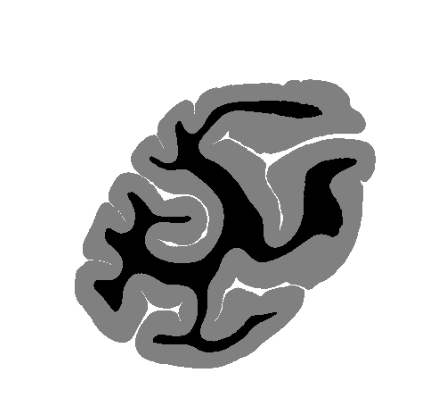

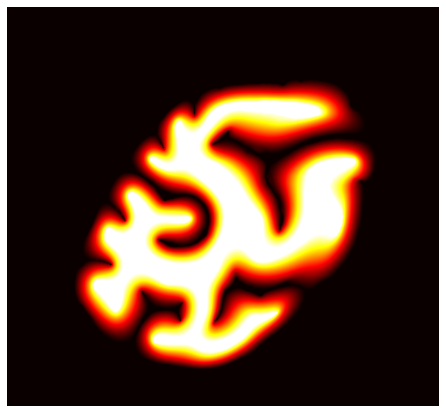

In [3]:
import pli.image as im

im.show(cortex_volume[:, 150, :])
im.show(laplace_volume[:, 150, :], cmap='hot')

Cutting direction: $y$

Laplace field $f(x, y, z)$

Gradient of Laplace field $\nabla f$

Cutting angle $\varphi = \arcsin(\frac{|{\nabla f}_y|}{\left\lVert\nabla f\right\rVert_2}) $

In [4]:
# Cortex class
gm_class = 2

# Sigmas of Gaussian kernel per axis
smooth_sigmas = (1.0, 1.4, 1.0)

# Multiply for numerical stability
factor = 100.

# Minimum in-plane length for stability
eps = 0.1

###

from scipy.ndimage import gaussian_filter

# Smooth before application of gradient to mitigate edge effects
laplace_volume_smoothed = factor * laplace_volume.astype(np.float64)
laplace_volume_smoothed = gaussian_filter(laplace_volume_smoothed, smooth_sigmas)

# Divide by spacing for isotropic gradient calculation
dx = np.gradient(laplace_volume_smoothed, axis=0) / laplace_spacing[0]
dy = np.gradient(laplace_volume_smoothed, axis=1) / laplace_spacing[1]
dz = np.gradient(laplace_volume_smoothed, axis=2) / laplace_spacing[2]

# Calculate in-plane and out-of plane vector components
grad_plane = np.maximum((dx ** 2 + dz ** 2) ** 0.5, eps)
grad_y_abs = np.abs(dy)

# Calculate cutting angle in degree from orientation vector
cutting_angle = np.arctan2(grad_y_abs, grad_plane)
cutting_angle = np.rad2deg(cutting_angle)

# Set cutting angle at background and white-matter to 0
cutting_angle[cortex_volume != gm_class] = 0.

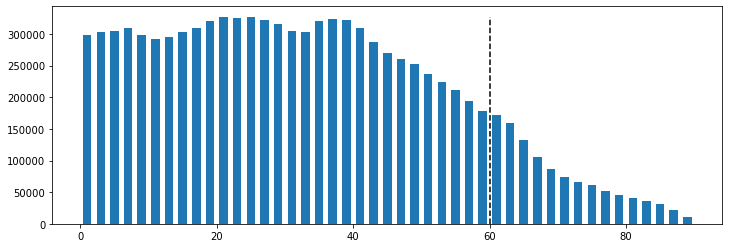

Fraction of voxels with cutting angle < 60°: 0.8877388582433796


In [52]:
bins = 45

section_margin = 30

###


import matplotlib.pyplot as plt

cutting_angle_margin = cutting_angle[:, section_margin:-section_margin, :]
cutting_angle_valid = cutting_angle_margin[cutting_angle_margin > 0.]

count, angle_bin = np.histogram(cutting_angle_valid, range=(0, 90), bins=bins)
angle_bin = (angle_bin + 1.)[:-1]

plt.figure(figsize=(12, 4))
plt.bar(angle_bin, height=count, width=1.25)
plt.vlines(60, ymin=0, ymax=np.max(count), color='black', linestyles='--')
plt.show()

good_degree = np.sum((cutting_angle_valid < 60.)) / len(cutting_angle_valid)

print("Fraction of voxels with cutting angle < 60°:", good_degree)

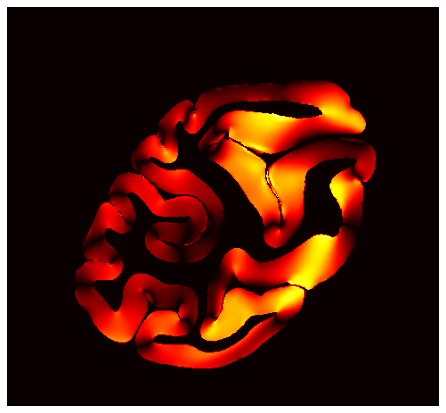

In [6]:
import pli.image as im

im.show(cutting_angle[:, 150, :], cmap='hot')

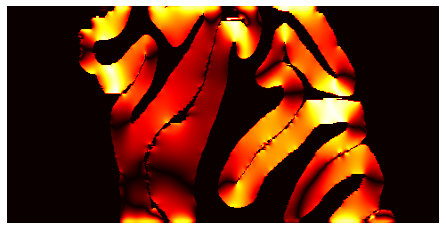

In [7]:
import pli.image as im

im.show(cutting_angle[200, :, :], cmap='hot')

In [8]:
from pli.data.functions import write_nifti

write_nifti("data/aa/volume/brain_visa/cutting_angle_6.nii", cutting_angle, laplace_nifti.affine, gzip=True)

Cutting angle verification
---

**Observation**: Cutting angle has equal distribution of angles < 45 degree and then suddenly drops.

Conduct an experiment where we look at the cutting angle distribution of a spherical volume, where we discard the last sections (the last 100 sections are missing for this vervet volume)

In [63]:
# Experiment to validate cutting angle histogram

granularity = 64

inner_radius = 0.8
outer_radius = 1.0
max_x = 0.85

###

xx, yy, zz = np.meshgrid(np.linspace(0, outer_radius, granularity), np.linspace(0, outer_radius, granularity), np.linspace(0, outer_radius, granularity))

@np.vectorize
def cut_angle(x, y, z):
    # Cut in x direction
    inplane_len = (y ** 2 + z ** 2) ** 0.5
    return np.rad2deg(np.arctan2(x, inplane_len))

@np.vectorize
def circle(x, y, z, radius=1., max_x=1.):
    vec_len = (x ** 2 + y ** 2 + z ** 2) ** 0.5
    return (vec_len < radius) & (x < max_x)

valid = circle(xx, yy, zz, outer_radius, max_x) & ~circle(xx, yy, zz, inner_radius, max_x)
ce = cut_angle(xx, yy, zz)

Warning! Printing mask for non integer like array


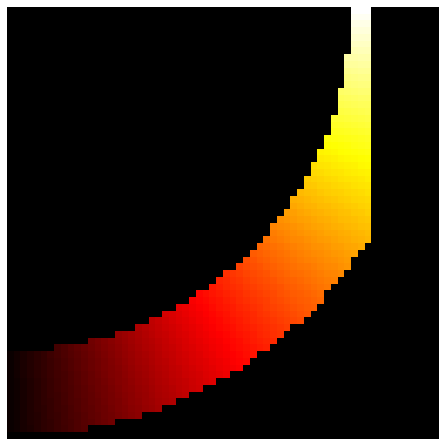

Warning! Printing mask for non integer like array


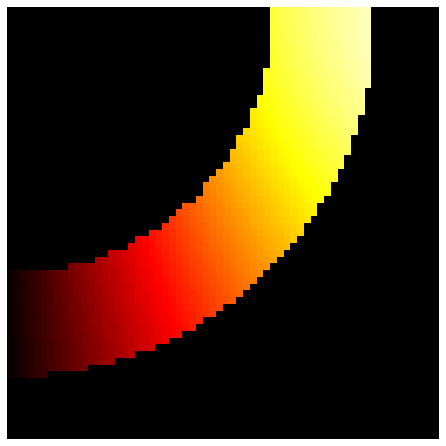

Warning! Printing mask for non integer like array


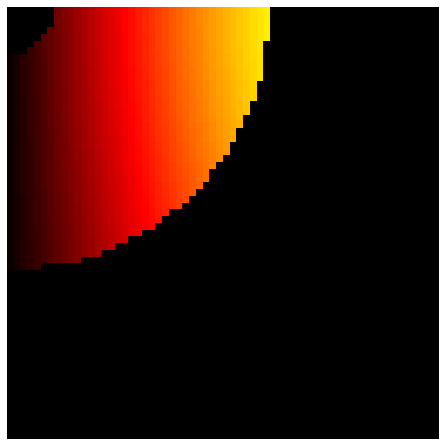

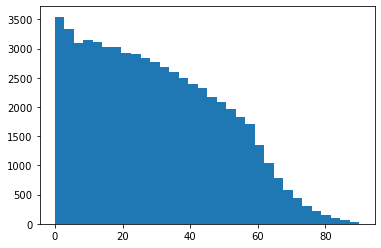

In [64]:
im.show(ce[..., 0], cmap='hot', mask=~valid[..., 0], mask_map='gray', alpha=1.0)
im.show(ce[..., 32], cmap='hot', mask=~valid[..., 32], mask_map='gray', alpha=1.0)
im.show(ce[..., 50], cmap='hot', mask=~valid[..., 50], mask_map='gray', alpha=1.0)

plt.hist(ce[valid], range=(0, 90), bins=32)
plt.show()